# CSE 6240 - Web Search & Text Mining - Homework 3

In [1]:
# __author__ = 'Bhanu Verma'
# GTid = '903151012'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import os, os.path
from scipy.sparse import lil_matrix,linalg
from scipy.sparse import csr_matrix
from scipy.sparse import identity
from scipy.sparse.linalg import norm,svds
from scipy.sparse.linalg import eigs,eigsh
from sklearn.cross_validation import train_test_split
from scipy.stats import pearsonr
import time
import pprint
%matplotlib inline

In [3]:
def get_matrix_dimensions():
    doc_size = 0
    vocab_size = 0
    with open(filepath, "r") as f:
        count = 0
        for line in f:
            line = line.rstrip('\n')
            if count==0:
                doc_size = int(line)
            elif count==1:
                vocab_size = int(line)
            else:
                break
                
            count+=1
    
    f.close()
    
    return (doc_size,vocab_size)

In [4]:
def populate_matrix():
    with open(filepath, "r") as f:
        count = 0
        for line in f:
            line = line.rstrip('\n')
            if count > 2:
                arr = line.split()
                i = int(arr[0])-1
                j = int(arr[1])-1
                val = int(arr[2])
                mat[i,j] = val
            count+=1
    f.close()

In [5]:
def get_triplet_list():
    triplet_list = []
    ordered_list = []
    for i in range(n_doc):
        # randomly generate 6 numbers, 1 extra to take care of the case where random number id is equal to i
        rand_arr = np.random.choice(n_doc,6,replace=False)
        doc_list = [] # list of indices of documents
        corr_val = [] # list of calculated correlation coefficients
        tuple_list = []
        
        # fill up correlation values
        for j in range(len(rand_arr)):
            if i!=j:
                a = get_dense_row(i)
                b = get_dense_row(rand_arr[j])
                pear_val = pearsonr(a,b) # it returns a tuple where first element is the coefficient value
                corr_val.append(pear_val[0])
                doc_list.append(rand_arr[j])
                if len(corr_val) == 5:
                    break

        # build up triplets
        for a in range(len(corr_val)):
            for b in range(a+1,len(corr_val)):
                if b < len(corr_val):
                    if corr_val[a] >= corr_val[b]:
                        triplet_list.append((i,doc_list[a],doc_list[b]))
                        tuple_list.append((i,doc_list[a],doc_list[b]))
                    else:
                        triplet_list.append((i,doc_list[b],doc_list[a]))
                        tuple_list.append((i,doc_list[b],doc_list[a]))
        
    return triplet_list

In [6]:
def get_dense_row(index):
    return dense_mat[index].tolist()[0] # fix for the issue, tolist() here returns matrix of rowsize 1

In [7]:
def get_sparse_row(index):
    return mat[index]

In [8]:
def dense(sparse):
    sparse = sparse.todense()
    return sparse[0].tolist()[0]

# Question 2.a - Generating Correlated Triplets

In [9]:
# get matrix dimensions
filepath = 'Data/docword.kos.txt'
size_tup = get_matrix_dimensions()

In [10]:
n_doc = size_tup[0]
n_vocab = size_tup[1]

In [11]:
# populate lil_matrix dimensions
mat = lil_matrix((size_tup[0],size_tup[1]),dtype=np.int32)
populate_matrix()

# convert lil_matrix to csr matrix for faster computation
mat = mat.tocsr()
dense_mat = mat.todense()

In [12]:
triplets = get_triplet_list()

In [13]:
# split triplet array into training and testing data
train,test = train_test_split(triplets, train_size = 0.8, random_state=42)

# OASIS Implementation

In [14]:
w = identity(n_vocab,format='csr')
c = 0.1

In [15]:
def get_similarity_score(a,w_mat,b):
    result = a*w_mat*b
    return result[0,0]

In [16]:
def get_loss(a_i,a_plus,a_neg,w_mat):
    res_a = get_similarity_score(a_i,w_mat,a_plus.transpose())
    res_b = get_similarity_score(a_i,w_mat,a_neg.transpose())
    val = 1-res_a+res_b
    return max(0,val)

In [17]:
def make_pd(w_mat):
    # Make matrix positive semi-definite
    w, v = eigsh(0.5 * (w_mat + w_mat.transpose()),10)  # eigvec in columns
    D = np.diagflat(np.maximum(w, 0.25))
    return csr_matrix(np.dot(np.dot(v, D), v.T))

In [18]:
def run_oasis(p_mat, train_data, test_data, w_mat, symmetric, pos_def=False):
    training_loss_list = []
    testing_loss_list = []
    
    if pos_def:
        train_size = 1
        iter_size = 50
    else:
        train_size = len(train_data)
        iter_size = 2740
        
    for i in range(train_size):
        p_i = p_mat[train_data[i][0]]
        p_plus = p_mat[train_data[i][1]]
        p_neg = p_mat[train_data[i][2]]

        loss = get_loss(p_i,p_plus,p_neg,w_mat)
        if (i%iter_size == 0):
            print "number of iterations - ", i

        if loss != 0:
            diff = (p_plus - p_neg).transpose()
            ones = np.ones((n_vocab,n_vocab))
            diff_csr = csr_matrix(diff.multiply(ones))
            elements = csr_matrix(p_i.multiply(ones))
            v_i = elements.multiply(diff_csr).transpose()
            norm_val = norm(v_i, 'fro')**2 
            tau = min(c,loss/norm_val)
            w_mat = w_mat + tau*v_i
            if symmetric:
                w_mat = (w_mat + w_mat.transpose())/2
            if pos_def:
                w_mat = make_pd(w_mat)

        train_loss = 0
        test_loss = 0

        if (i%iter_size == 0):
            if (not pos_def):
                # calculate Training Loss
                for z in range(len(train_data)):
                    a_i = p_mat[train_data[z][0]]
                    a_plus = p_mat[train_data[z][1]]
                    a_neg = p_mat[train_data[z][2]]
                    train_loss += get_loss(a_i,a_plus,a_neg,w_mat)
                train_loss = train_loss/len(train_data)
                training_loss_list.append(train_loss)

                # calculate Testing Loss
                for k in range(len(test_data)):
                    t_i = p_mat[test_data[k][0]]
                    t_plus = p_mat[test_data[k][1]]
                    t_neg = p_mat[test_data[k][2]]
                    test_loss += get_loss(t_i,t_plus,t_neg,w_mat)
                test_loss = test_loss/len(test_data)
                testing_loss_list.append(test_loss)

                print "Training Error", train_loss
                print "Testing Error", test_loss
                print "-----------------------------"
            
    return w_mat, training_loss_list, testing_loss_list

# Question 1 - OASIS for non-symmetric W

In [19]:
w,train_loss_arr,test_loss_arr = run_oasis(mat,train,test,w,False,False)

number of iterations -  0
Training Error 1.52281341108
Testing Error 1.56341107872
-----------------------------
number of iterations -  2740
Training Error 0.611494295222
Testing Error 0.719358454796
-----------------------------
number of iterations -  5480
Training Error 0.471853629944
Testing Error 0.609063173948
-----------------------------
number of iterations -  8220
Training Error 0.407642545965
Testing Error 0.580176775624
-----------------------------
number of iterations -  10960
Training Error 0.345699464572
Testing Error 0.551879769786
-----------------------------
number of iterations -  13700
Training Error 0.281326645836
Testing Error 0.510808596238
-----------------------------
number of iterations -  16440
Training Error 0.248157356469
Testing Error 0.502135451374
-----------------------------
number of iterations -  19180
Training Error 0.214484722345
Testing Error 0.49162703545
-----------------------------
number of iterations -  21920
Training Error 0.18499271295

# Question 2.b - Training Error Plot

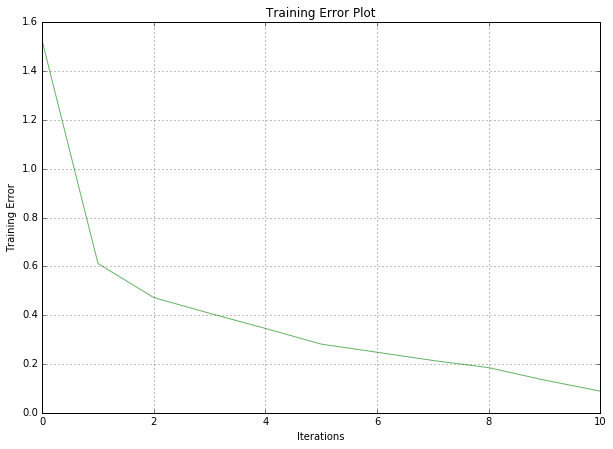

In [20]:
plt.figure(1, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Training Error')
plt.title('Training Error Plot')
plt.plot(train_loss_arr, color='green',alpha=0.6)
plt.grid(True)

# Question 2.c - Testing Error Plot

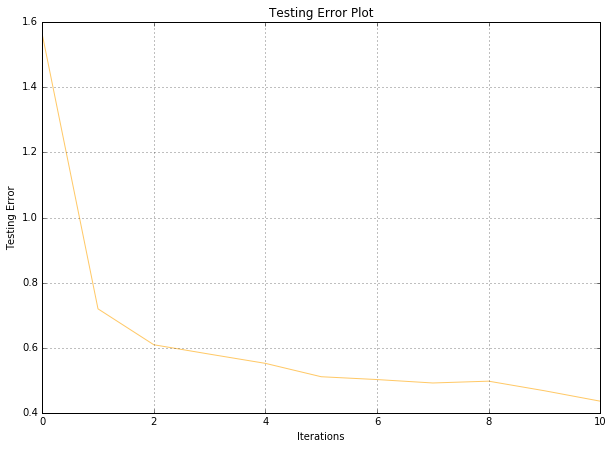

In [21]:
plt.figure(1, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Testing Error')
plt.title('Testing Error Plot')
plt.plot(test_loss_arr, color='orange',alpha=0.6)
plt.grid(True)

# Question 3 - OASIS for symmetric W

In [22]:
w_sym,train_loss_arr_sym,test_loss_arr_sym = run_oasis(mat,train,test,w,True,False)

number of iterations -  0
Training Error 0.0887820004838
Testing Error 0.435520348031
-----------------------------
number of iterations -  2740
Training Error 0.311465942692
Testing Error 0.538608918508
-----------------------------
number of iterations -  5480
Training Error 0.287446893517
Testing Error 0.524578650709
-----------------------------
number of iterations -  8220
Training Error 0.273401963155
Testing Error 0.525811317452
-----------------------------
number of iterations -  10960
Training Error 0.259230027143
Testing Error 0.521019762049
-----------------------------
number of iterations -  13700
Training Error 0.236728249296
Testing Error 0.505915058337
-----------------------------
number of iterations -  16440
Training Error 0.225297924321
Testing Error 0.504590060689
-----------------------------
number of iterations -  19180
Training Error 0.224638451782
Testing Error 0.515553911316
-----------------------------
number of iterations -  21920
Training Error 0.2127151

# Question 3.a - Testing & Training Error for symmetric W

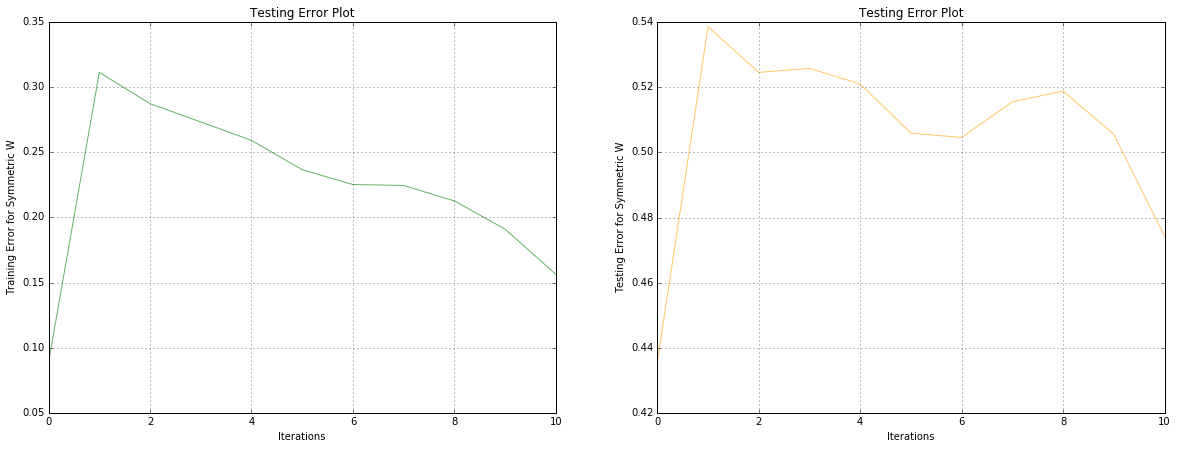

In [23]:
plt.figure(2, figsize=(20, 7))
plt.subplot(1,2,1)
plt.xlabel('Iterations')
plt.ylabel('Training Error for Symmetric W')
plt.title('Testing Error Plot')
plt.plot(train_loss_arr_sym, color='green',alpha=0.6)
plt.grid(True)

plt.subplot(1,2,2)
plt.xlabel('Iterations')
plt.ylabel('Testing Error for Symmetric W')
plt.title('Testing Error Plot')
plt.plot(test_loss_arr_sym, color='orange',alpha=0.6)
plt.grid(True)
plt.show()

# Question 3.b - Eigenvalues of the W matrix

In [24]:
start_time = time.time()
vals,vecs = eigsh(w_sym,k=n_vocab-1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 952.258299112 seconds ---


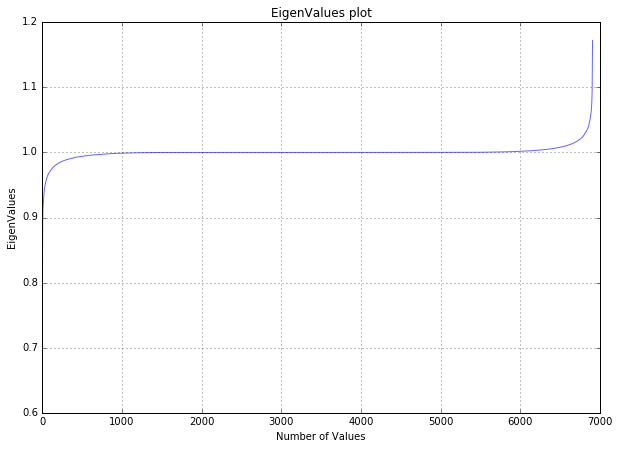

In [25]:
plt.figure(3, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Number of Values')
plt.ylabel('EigenValues')
plt.title('EigenValues plot')
plt.plot(vals, color='blue',alpha=0.6)
plt.grid(True)

In [26]:
print train_loss_arr

[1.5228134110787173, 0.61149429522182319, 0.47185362994412583, 0.40764254596479188, 0.34569946457171041, 0.28132664583625927, 0.24815735646902196, 0.21448472234491087, 0.18499271295315528, 0.13399014631601247, 0.088896350050766668]


In [27]:
print test_loss_arr

[1.5634110787172011, 0.7193584547964168, 0.60906317394811693, 0.58017677562360026, 0.55187976978606512, 0.5108085962377269, 0.50213545137389226, 0.4916270354499081, 0.49717222304111425, 0.46778221259498348, 0.43573543869607323]


In [28]:
print train_loss_arr_sym

[0.088782000483808396, 0.31146594269202466, 0.28744689351729158, 0.2734019631550354, 0.25923002714321403, 0.23672824929607461, 0.22529792432088433, 0.2246384517817181, 0.21271514731379879, 0.191062553241759, 0.15632659347649769]


# Question 4 - OASIS for positive definite W

In [ ]:
# w_psd,train_empty,test_empty = run_oasis(mat,train,test,w,True,True)

In [ ]:
start_time = time.time()
u,s,vt = svds(w_sym,k=5)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
a = np.dot(np.dot(u,np.diagflat(s)),vt)